In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../scripts/")
import warnings
import numpy as np
import aif360
import eval_metrics as evaluation
import load_data as data_load
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover
warnings.filterwarnings("ignore")


`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [3]:
path_to_csv = '../dataset/dataset.csv'
test_size = 0.3
random_seed = 1

In [4]:
# X_train, X_test, y_train, y_test, sens_train, sens_test= data_load.load_preprocessing_split(path_to_csv, split_data = True, unawareness= True,
#                                                                                          test_size=test_size, random_state=random_seed)

df, X, y, sensitive_attribute = data_load.load_preprocessing_split(path_to_csv, split_data = False, unawareness= False,
                                                                                         test_size=test_size, random_state=random_seed)

In [5]:

binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=['Target'],
    protected_attribute_names=['Gender'])

## Test for Fairness on original datasets before

In [6]:
metric = BinaryLabelDatasetMetric(binaryLabelDataset, 
                                  unprivileged_groups=[{'Gender': 0}], 
                                  privileged_groups=[{'Gender': 1}])
print("Disparate Impact: ", metric.disparate_impact())
print("Statistical Parity Difference: ", metric.statistical_parity_difference())

Disparate Impact:  0.5572433881066498
Statistical Parity Difference:  -0.1994681137128782


In [7]:
df_female = df[df['Gender'] == 0]# females

df_male = df[df['Gender'] == 1]# males

female_nodrop = df_female['Target'].value_counts()[0]
female_drop = df_female['Target'].value_counts()[1]

male_nodrop = df_male['Target'].value_counts()[0]
male_drop = df_male['Target'].value_counts()[1]

print(f'Number of females that drop out are {female_drop} and no drop out {female_nodrop}, hence disparate is {female_nodrop/len(df_female)}')
print(f'Number of males that drop out are {male_drop} and no drop out {male_nodrop}, hence disparate impact is {male_nodrop/len(df_male)}')

Number of females that drop out are 720 and no drop out 2148, hence disparate is 0.7489539748953975
Number of males that drop out are 701 and no drop out 855, hence disparate impact is 0.5494858611825193


### Reweighting (Pre Processing Method)

In [8]:
'''
Gender 

1: Male
0: Female
'''

from aif360.algorithms.preprocessing import Reweighing
RW = Reweighing(unprivileged_groups=[{'Gender': 0}], 
                privileged_groups=[{'Gender': 1}])
dataset_transf = RW.fit_transform(binaryLabelDataset)

### Test for Fairness on original datasets after accounting for fairness

In [9]:

metric = BinaryLabelDatasetMetric(dataset_transf, 
                                  unprivileged_groups=[{'Gender': 0}], 
                                  privileged_groups=[{'Gender': 1}])
print("Disparate Impact: ", metric.disparate_impact())
print("Statistical Parity Difference: ", metric.statistical_parity_difference())

Disparate Impact:  1.0
Statistical Parity Difference:  0.0


In [10]:
features = dataset_transf.features
labels = dataset_transf.labels.reshape(-1, 1)  # Ensure labels are in the correct shape
feature_names = dataset_transf.feature_names

label_name = dataset_transf.label_names[0] if isinstance(dataset_transf.label_names, (list, np.ndarray)) else dataset_transf.label_names

columns = feature_names + [label_name]  # Ensure this is a flat list of strings
fair_df = pd.DataFrame(data=np.hstack((features, labels)), columns=columns)


In [11]:
fair_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1.0,8.0,5.0,2.0,1.0,1.0,1.0,13.0,10.0,6.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,10.8,1.4,1.74,1.0
1,1.0,6.0,1.0,11.0,1.0,1.0,1.0,1.0,3.0,4.0,...,0.0,6.0,6.0,6.0,13.666667,0.0,13.9,-0.3,0.79,0.0
2,1.0,1.0,5.0,5.0,1.0,1.0,1.0,22.0,27.0,10.0,...,0.0,6.0,0.0,0.0,0.000000,0.0,10.8,1.4,1.74,1.0
3,1.0,8.0,2.0,15.0,1.0,1.0,1.0,23.0,27.0,6.0,...,0.0,6.0,10.0,5.0,12.400000,0.0,9.4,-0.8,-3.12,0.0
4,2.0,12.0,1.0,3.0,0.0,1.0,1.0,22.0,28.0,10.0,...,0.0,6.0,6.0,6.0,13.000000,0.0,13.9,-0.3,0.79,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1.0,1.0,6.0,15.0,1.0,1.0,1.0,1.0,1.0,6.0,...,0.0,6.0,8.0,5.0,12.666667,0.0,15.5,2.8,-4.06,0.0
4420,1.0,1.0,2.0,15.0,1.0,1.0,19.0,1.0,1.0,10.0,...,0.0,6.0,6.0,2.0,11.000000,0.0,11.1,0.6,2.02,1.0
4421,1.0,1.0,1.0,12.0,1.0,1.0,1.0,22.0,27.0,10.0,...,0.0,8.0,9.0,1.0,13.500000,0.0,13.9,-0.3,0.79,1.0
4422,1.0,1.0,1.0,9.0,1.0,1.0,1.0,22.0,27.0,8.0,...,0.0,5.0,6.0,5.0,12.000000,0.0,9.4,-0.8,-3.12,0.0


In [13]:

from sklearn.model_selection import train_test_split
y = fair_df['Target']
X = fair_df.drop(columns=['Target', 'Gender']) #excludes gender from X features
sensitive_attribute = fair_df[['Marital status', 'Nacionality', 'Gender']]

X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(X, y, sensitive_attribute, test_size=0.3, random_state=1)
    

### Logistic Regression

In [14]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train,y_train)
mymask= sens_test.Gender
LR_dp, LR_Eo, LR_fpr, LR_acc, LR_recall, LRpreds= evaluation.model_metrics(logistic_model, X_test, y_test, mask=mymask,  fair_metrics= True)
maleLR_dp, maleLR_Eo, maleLR_fpr, maleLR_acc, maleLR_recall, LRpreds = evaluation.model_metrics(logistic_model, X_test, y_test, mask=1-mymask,  fair_metrics= True)

In [15]:
maleLR_dp, maleLR_Eo, maleLR_fpr, maleLR_acc, maleLR_recall

(0.1882750845546787,
 0.7213930348258707,
 0.03206997,
 0.9120631341600902,
 0.7213930348258707)

### Random Forest

In [17]:
rf_classfier = RandomForestClassifier()
rf_classfier.fit(X_train,y_train)
RF_dp, RF_Eo, RF_fpr, RF_acc, RF_recall, RFpreds= evaluation.model_metrics(rf_classfier, X_test, y_test, mask=mymask,  fair_metrics= True)
maleRF_dp, maleRF_Eo, maleRF_fpr, maleRF_acc, maleRF_recall, RFpreds= evaluation.model_metrics(rf_classfier, X_test, y_test, mask=1-mymask,  fair_metrics= True)

### Decision Tree Classifier

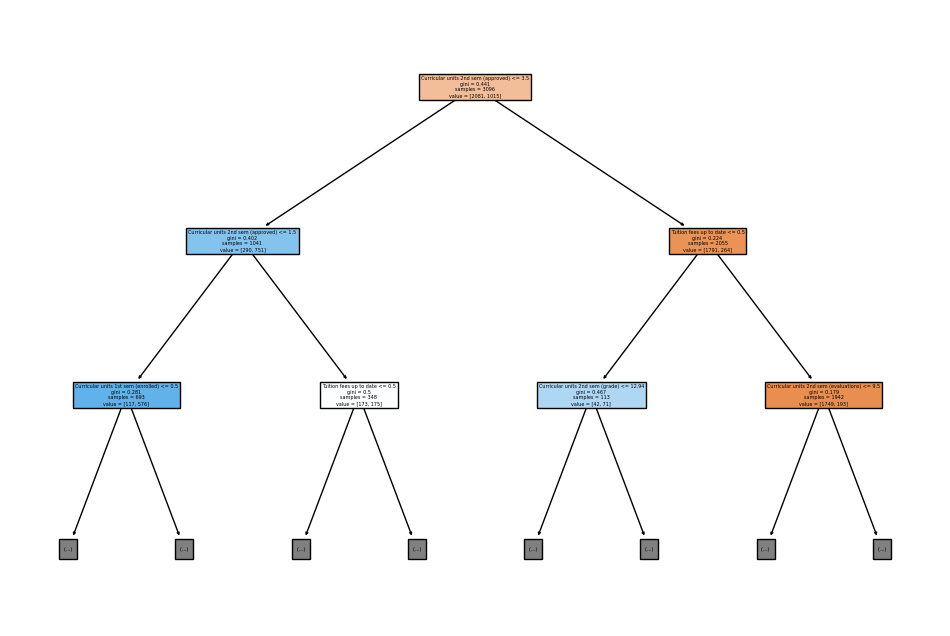

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
clf_preds = clf.predict(X_test)
clf_dp, clf_Eo, clf_fpr, clf_acc, clf_recall, clfpreds= evaluation.model_metrics(clf, X_test, y_test, mask=mymask,  fair_metrics= True)
maleclf_dp, maleclf_Eo, malelf_fpr, maleclf_acc, maleclf_recall, clfpreds = evaluation.model_metrics(clf, X_test, y_test, mask=1-mymask,  fair_metrics= True)

feature_names= X_test.columns.to_list()
plt.figure(figsize=(12, 8))
plot_tree(clf,max_depth = 2, filled=True, feature_names=feature_names)
plt.show()

In [19]:
# Convert numpy arrays to DataFrames
LRpreds_df = pd.DataFrame(LRpreds)
RFpreds_df = pd.DataFrame(RFpreds)
clfpreds_df = pd.DataFrame(clfpreds)
col_names = ['LRpredictions', 'RFpredictions', 'clfpredictions']
# Concatenate the DataFrames
concatenated_df = pd.concat([LRpreds_df, RFpreds_df, clfpreds_df], axis=1)
concatenated_df.columns = col_names

In [22]:

# Define a dictionary for males
malemodels_eval = {
    "Metrics": ["Demographic Parity", "EO", "FPR", "Accuracy", "Recall"],
    "Linear Regression": [maleLR_dp, maleLR_Eo, maleLR_fpr, maleLR_acc, maleLR_recall],
    "Random Forest": [maleRF_dp, maleRF_Eo, maleRF_fpr, maleRF_acc, maleRF_recall],
    "Decision Tree": [maleclf_dp, maleclf_Eo, malelf_fpr, maleclf_acc, maleclf_recall]
}

# Convert the dictionary to a pandas DataFrame
male_eval_df = pd.DataFrame(malemodels_eval)

# Display the DataFrame
male_eval_df

,Metrics,Linear Regression,Random Forest,Decision Tree
0,Demographic Parity,0.188275,0.184893,0.235626
1,EO,0.721393,0.716418,0.676617
2,FPR,0.032070,0.029155,0.106414
3,Accuracy,0.912063,0.913191,0.844419
4,Recall,0.721393,0.716418,0.676617
